## Introduction

This notebook attempts to visualise the employment growth rates and claim growth rates in the canton of Basel-Stadt and see if they're correlated for every year.

Please note that the data for employment growth rates and claim growth rates was generated for this demo

GeoJSON data for the canton of Basel Stadt was obtained using the API at https://wfs.geo.bs

### Parse the GeoJSON data into a dataframe

We begin by creating a Pandas dataframe with the boundaries of the residentials quarters in Basel-Stadt. This data is publically available using the API at https://wfs.geo.bs

In [1]:
import geopandas as gpd

In [2]:
BOUNDARIES = 'datasets/WE_Wohnviertel.json'

In [3]:
boundaries_df = gpd.read_file(BOUNDARIES)
boundaries_df = boundaries_df.iloc[:, 1:]
boundaries_df.columns = ['region', 'geometry']
boundaries_df.set_index('region', inplace=True)

### Parse the Employment Growth Rates and Claim Growth Rates

The employment Growth Rate denotes the increase in employment rate every year in Basel-Stadt.

The claim growth rate denotes the increase in total claim values every year in Basel-Stadt. This is an example of _confidential data_ that needs to be securely accessed.

In [4]:
EGR_FILE = 'datasets/egr_data.csv'
CGR_FILE = 'datasets/cgr_data.csv'

In [5]:
import pandas as pd

In [6]:
def process_df(df):
    df.rename(columns={'Unnamed: 0': 'region'}, inplace=True)
    df.set_index('region', inplace=True)

In [7]:
egr_df = pd.read_csv(EGR_FILE)
process_df(egr_df)

In [8]:
cgr_df = pd.read_csv(CGR_FILE)
process_df(cgr_df)

In [9]:
egr_df.head()

2012      2013      2014      2015      2016      2017
region                                                                   
Matthäus      -0.094552 -1.351567  1.094053  0.101896  0.819751  1.476425
Klybeck       -0.380515 -0.206079  0.319034 -0.982633 -0.993697  0.510336
Kleinhüningen  2.264756  1.469018 -0.418371 -1.161725  1.656842 -1.750684
Riehen        -0.970848  0.238091  0.443750 -0.110771 -1.969665 -0.340080
Gotthelf      -0.215146  0.976213  0.257339 -0.496314 -0.145869  0.266796

In [10]:
cgr_df.head()

2012      2013      2014      2015      2016      2017
region                                                                   
Matthäus       0.792444 -1.762946  0.254281  0.762513  0.916994  0.794527
Klybeck       -0.113676  0.606521  0.068596 -0.518868 -0.882560 -0.220348
Kleinhüningen  1.761395  1.080664  0.266036 -0.779365  2.135288 -0.584298
Riehen        -1.521147  0.724301 -0.306158 -0.356819 -1.347238 -1.504098
Gotthelf       0.013202  0.270472  0.741481 -0.489611 -0.226291  0.695766

### Helper functions for plotting data

We begin by defining helper functions that will be used for plotting Geo data
along with the EGR and CGR data

In [11]:
from bokeh.io import curdoc, output_notebook, show
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool, Slider
from bokeh.palettes import brewer
from bokeh.layouts import widgetbox, row, column, gridplot

In [12]:
output_notebook()

Loading BokehJS ...

In [13]:
palette = brewer['YlGnBu'][8]
palette = palette[::-1]

In [14]:
def generate_plot(data, title, field_title, field):
    data = data.reset_index()
    json_data = data.to_json()
    
    source = GeoJSONDataSource(geojson=json_data)
    
    #color_mapper = LinearColorMapper(palette = palette, low=data[field].min(), high=data[field].max())
    color_mapper = LinearColorMapper(palette=palette, low=-2.5, high=2.5)
    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8, width=300, height=10,
                        border_line_color=None,location = (0,0), orientation = 'horizontal')
    
    p = figure(title=title, plot_height=400, plot_width=450, toolbar_location=None, tools="hover")
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.xaxis.major_tick_line_color = None  # turn off x-axis major ticks
    p.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks

    p.yaxis.major_tick_line_color = None  # turn off y-axis major ticks
    p.yaxis.minor_tick_line_color = None  # turn off y-axis minor ticks
    
    p.xaxis.major_label_text_font_size = '0pt'  # turn off x-axis tick labels
    p.yaxis.major_label_text_font_size = '0pt'  # turn off y-axis tick labels
    
    hover = p.select_one(HoverTool)
    hover.point_policy = "follow_mouse"
    hover.tooltips = [
        ("Name", "@region"),
        (field_title, f"@{field}"),
    ]
    
    p.patches('xs','ys', source=source, fill_color={'field' : field, 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
    p.add_layout(color_bar, 'below')
    return p

In [15]:
def gen_grid(data, start, end, title, field_title):
    grid = []
    row = []
    for i in range(start, end):
        if i != start and i % 2 == 0:
            grid.append(row)
            row = []
        title_yr = '%s (%s-%s)' % (title, i-1, i)
        row.append(generate_plot(data, title_yr, field_title, str(i)))
    return grid

### Visualise Employment Growth Rate

In [16]:
egr_geo = boundaries_df.merge(egr_df, left_index=True, right_index=True)
grid1 = gen_grid(egr_geo, 2012, 2017, 'Employment Growth Rate in Canton Basel Stadt', 'Employment Growth Rate')

In [17]:
gp = gridplot(grid1)
show(gp)

### Visualise Claim Growth Rate

In [18]:
cgr_geo = boundaries_df.merge(cgr_df, left_index=True, right_index=True)
grid2 = gen_grid(cgr_geo, 2012, 2017, 'Claim Growth Rate in Canton Basel Stadt', 'Claim Growth Rate')

In [19]:
gp = gridplot(grid2)
show(gp)

### Let's see the plots together grouped by year

In [20]:
grid = []
for e, c in zip(grid1, grid2):
    grid.append([e[0], c[0]])
    grid.append([e[1], c[1]])

In [21]:
gp = gridplot(grid)
show(gp)

### Correlation between employment and claim growth rates grouped by year

In [22]:
from scipy.stats import pearsonr

In [23]:
rhos = []

for year in range(2012, 2018):
    rhos.append(pearsonr(egr_df[str(year)], cgr_df[str(year)])[0])

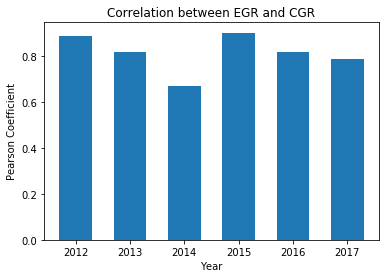

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

x_range = [str(year) for year in range(2012, 2018)]
plt.bar(x=x_range, height=rhos, width=0.6)
plt.title('Correlation between EGR and CGR')
plt.xlabel('Year')
plt.ylabel('Pearson Coefficient')
plt.savefig('pearson.pdf')

### Conclusion

Looking at the visualisations, we hypothesise if the increase in claim growth rates is correlated with the employment growth rate in Basel-Stadt

Looking at the plot above, we see the Pearson coefficient is around 0.8 which demonstrates the two are positively
correlated